In [60]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp
import random
import gillespie 
from scipy.interpolate import interp1d
import bisect

#### ODE NOISE 

In [61]:
mu=0.05
c=0.01
rho=0.5
K=500
T=500
sto_realisations=50


In [62]:
def F(X,t):
    w,m=X[0],X[1]
    return (c*w*(K-w-rho*m), c*m*(K-w-rho*m))

temps=np.linspace(0,500,500)
sol=odeint(F,[87,58],temps)


In [63]:
w=sol[:,0]
m=sol[:,1]
h=m/(w+m)
h

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.

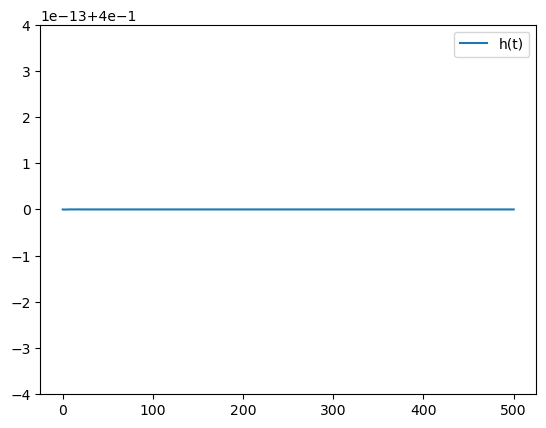

In [64]:
#plt.plot(temps, w, "r--",label='w(t)')
#plt.plot(temps, m,"b--",label="m(t)")

plt.plot(temps,h,label='h(t)')

# Ajout de légendes
plt.legend()

### SSA


In [6]:
mu=0.05
c=0.01
rho=0.5
K=50
T=500
sto_realisations=200

# Matrice de stoichiométrie
V = np.array([[-1, 0, 1, 0],
              [0, -1, 0, 1]])

In [7]:
h0=0.4

#on essaye d'éviter la division par 0 rho==0 and h0==1
if (rho==0 and h0==1): 
    w0=0
    m0=K
else:
    w0 = (1-h0)*K/(1-h0+rho*h0)
    m0 = h0*K/(1-h0+rho*h0)

# Initialisation de l'état initial
X = np.array([w0,m0])
print(X)

[37.5 25. ]


In [8]:
def rate_function(rates):
    return max(rates,0)  

In [9]:
from tqdm import tqdm
# Simulation des populations
all_times = []
all_populations = []

for sim in tqdm(range(sto_realisations), desc="Simulations"):
    t = 0
    times_sim = [t]
    X = np.array([w0,m0])
    pop_sim = [X.copy()]
   

    while t <= T:
        # Calcul des taux
        a = np.array([rate_function(mu * X[0]),
                      rate_function(mu * X[1]),
                      rate_function((mu + c * (K - X[0] - rho*X[1]))*X[0]),
                      rate_function((mu +c * (K - X[0] - rho*X[1]))*X[1])])
        
        
        # Somme des taux
        somme = np.sum(a)
        # Debug print
        #print(f'Simulation {sim}, t = {t:.4f}, X = {X}, a = {a}, rate_sum = {somme:.4f}')
        if somme==0:
            print('No more events possible, breaking out of the loop.')
            break 
            
         # Sélection de la réaction
        r1 = np.random.rand()
        r_compare= r1*somme
        
        cumulative_sum = np.cumsum(a)
        j = np.searchsorted(cumulative_sum, r_compare)
        # Debugging information
        #print(f'Random number ξ1: {r1}')
        #print(f'Threshold for reaction selection: {r_compare}')
        #print(f'Cumulative sums: {cumulative_sum}, Selected reaction: {j}')
        
           # Vérification que j est bien sélectionné parmi les réactions disponibles
        if j >= len(a):
            print(f'Error: j ({j}) is out of bounds for array a with length {len(a)}.')
            break
            
            
        X += V[:, j ]
        
        
        # Calcul du temps d'événement
        r2 = np.random.rand()
        tau = np.log(1 / r2) / somme
        
        # Mettre à jour le temps
        t += tau
        if t > T:
            break
        times_sim.append(t)
        pop_sim.append(X.copy())
    
    # Enregistrer les résultats de la simulation
    all_times.append(times_sim)
    all_populations.append(pop_sim)


Simulations: 100%|██████████| 200/200 [00:14<00:00, 14.05it/s]


In [46]:
total_time=500
time_points = np.linspace(0, total_time, num=20)


# Calculer la fraction de mutants et l'ensemble moyen
h_ensemble = np.zeros((len(time_points), sto_realisations))
m_ensemble=np.zeros((len(time_points), sto_realisations))
w_ensemble=np.zeros((len(time_points), sto_realisations))



for i in range(sto_realisations):
    times = all_times[i]
    populations = all_populations[i]
    
    for idx, t in enumerate(time_points):
        if t <= times[-1]:
            j = np.searchsorted(times, t)
            W, M = populations[j] if j < len(populations) else populations[-1]
            h_ensemble[idx, i] = M / (W + M)
            m_ensemble[idx,i]=M
            w_ensemble[idx,i]=W
        else:
            h_ensemble[idx, i] = h_ensemble[idx - 1, i]
            m_ensemble[idx, i] = m_ensemble[idx - 1, i]
            w_ensemble[idx, i] = w_ensemble[idx - 1, i]

h_mean = np.mean(h_ensemble, axis=1)
m_mean = np.mean(m_ensemble, axis=1)
w_mean = np.mean(w_ensemble, axis=1)

In [47]:
## pour chaque simulation on a h,w,m pour chaque point de temps 
# Affichage des résultats pour vérification
print("h_ensemble :", h_ensemble)
np.shape(h_ensemble)
#print("m_ensemble :", m_ensemble)
#print("w_ensemble :", w_ensemble)

h_ensemble : [[0.4        0.4        0.4        ... 0.4        0.4        0.4       ]
 [0.58394161 0.41860465 0.42477876 ... 0.22429907 0.37795276 0.39370079]
 [0.384      0.56115108 0.25210084 ... 0.34710744 0.48888889 0.45255474]
 ...
 [0.35772358 0.63225806 0.         ... 0.11009174 0.55944056 1.00492611]
 [0.35772358 0.65734266 0.         ... 0.12389381 0.60645161 1.00497512]
 [0.35772358 0.65734266 0.         ... 0.12389381 0.60645161 1.00497512]]


(20, 200)

In [48]:
## tendance moyennes de h,w et m au cours du temps 
# Affichage des résultats pour vérification
print("h_mean :", h_mean)
#print("m_mean :", m_mean)
#print("w_mean :", w_mean)
len(h_mean) ## longueur = nombre de points de temps 

h_mean : [0.4        0.39196094 0.38001141 0.37679002 0.37426784 0.38197941
 0.38036816 0.37789971 0.3768424  0.36648055 0.36823592 0.37068302
 0.36527755 0.36891151 0.36520501 0.35612915 0.3595935  0.36174147
 0.37237507 0.37237507]


20

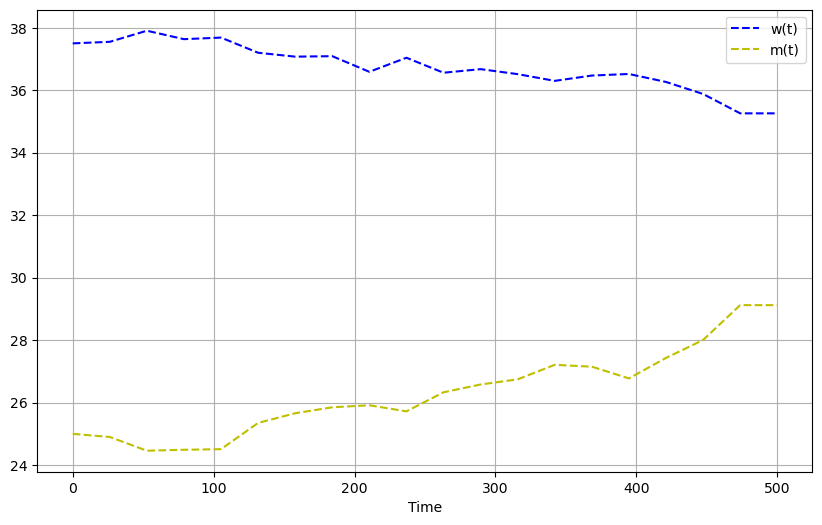

In [49]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.plot(time_points,w_mean,"b--",label="w(t)")
plt.plot(time_points,m_mean,"y--",label="m(t)")
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
m_std=np.std(m_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
m_sem = m_std/ np.sqrt(sto_realisations)
m_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([0.        , 0.58732444, 0.79337381, 0.93912166, 1.00381746,
       1.0983112 , 1.23813246, 1.32230386, 1.41029744, 1.52171219,
       1.64100746, 1.67117264, 1.8078025 , 1.83989932, 1.8878791 ,
       1.97960144, 2.04219869, 2.13689608, 2.18509222, 2.18509222])

In [51]:
w_std=np.std(w_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
w_sem = w_std/ np.sqrt(sto_realisations)
w_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([0.        , 0.31636609, 0.42474095, 0.48346031, 0.52211481,
       0.56378187, 0.64142176, 0.68710225, 0.72385047, 0.76285123,
       0.79992625, 0.85753826, 0.91832667, 0.92981181, 0.96218267,
       1.000049  , 1.02871224, 1.07288303, 1.10738972, 1.10738972])

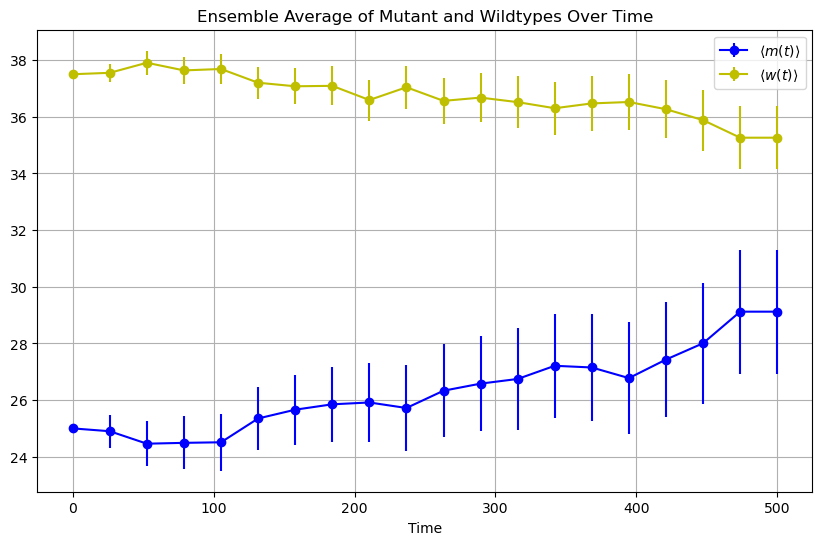

In [52]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, m_mean, yerr=m_sem, fmt='b-', marker='o', label=r'$\langle m(t) \rangle$')
plt.errorbar(time_points, w_mean, yerr=w_sem, fmt='y-', marker='o', label=r'$\langle w(t) \rangle$')
plt.xlabel('Time')
plt.title('Ensemble Average of Mutant and Wildtypes Over Time')
plt.legend()
plt.grid(True)
plt.show()

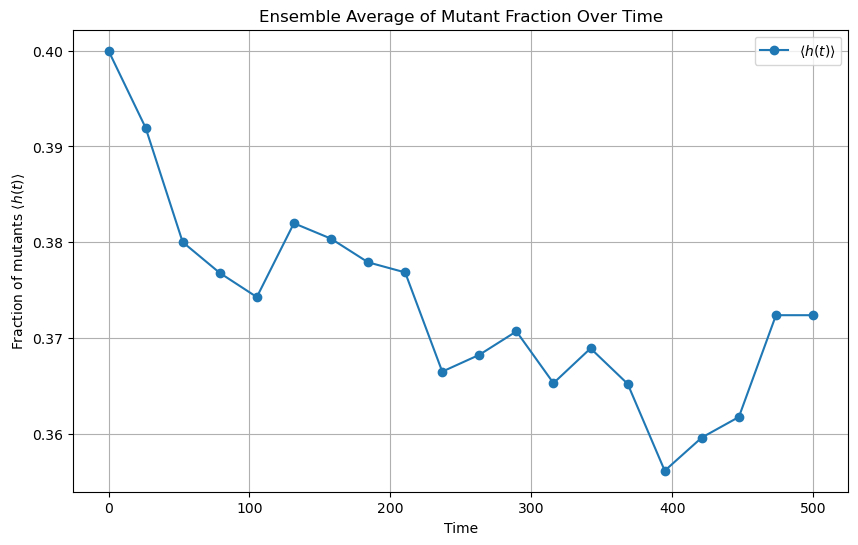

In [34]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.plot(time_points, h_mean, marker='o', label=r'$\langle h(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
h_std=np.std(h_ensemble,axis=1)
#h_std #écart-type des moyennes des simulations 
h_sem = h_std/ np.sqrt(sto_realisations)
h_sem #SEM pour chaque point de temps 
#estimation de l'incertitude de la moyenne des simulations à chaque instant dans le temps

array([0.        , 0.00739273, 0.01006126, 0.0117222 , 0.01265341,
       0.01360901, 0.01509193, 0.01616828, 0.01722851, 0.01809965,
       0.01897933, 0.01954849, 0.02069179, 0.0209908 , 0.02145863,
       0.02204556, 0.02263849, 0.02344121, 0.02416105, 0.02416105])

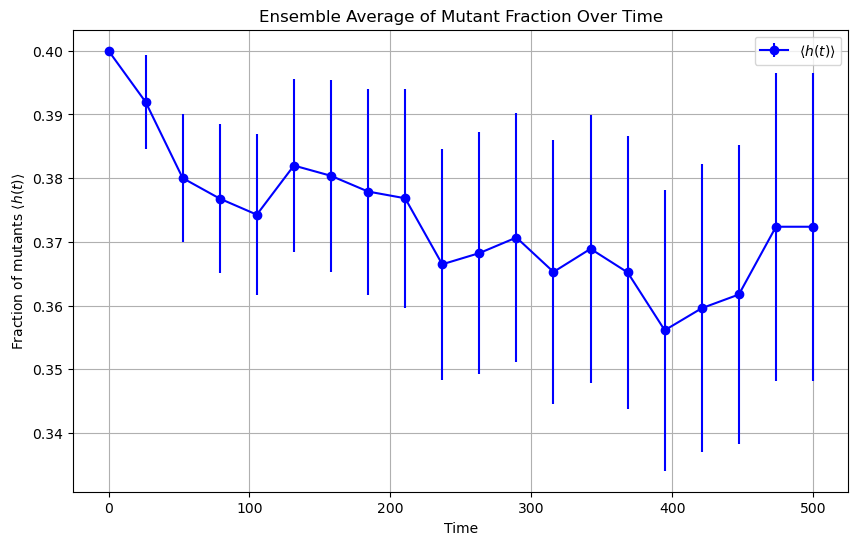

In [54]:
# Tracer les résultats avec des barres d'erreur
plt.figure(figsize=(10, 6))
plt.errorbar(time_points, h_mean, yerr=h_sem, fmt='b-', marker='o', label=r'$\langle h(t) \rangle$')
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Ensemble Average of Mutant Fraction Over Time')
plt.legend()
plt.grid(True)
plt.show()

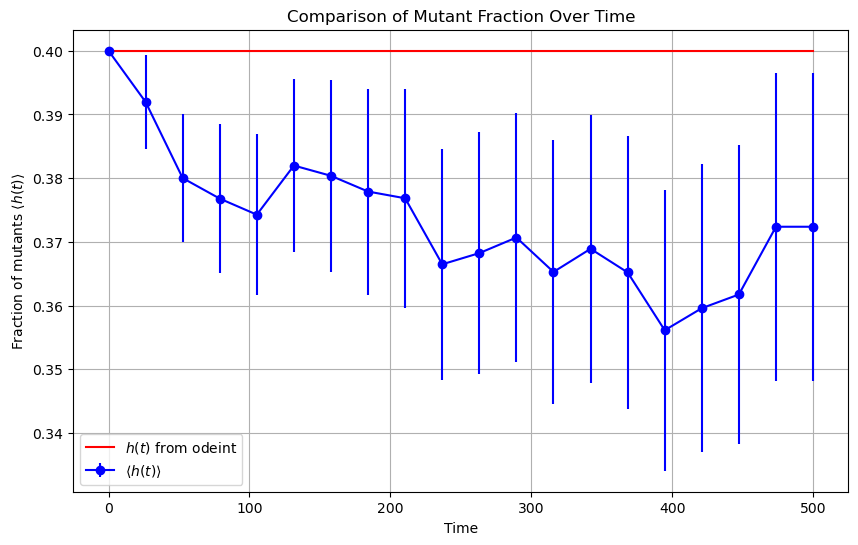

In [55]:

# Tracé des courbes
plt.figure(figsize=(10, 6))

# Tracer la courbe obtenue à partir des simulations
plt.errorbar(time_points, h_mean, yerr=h_sem, fmt='b-', marker='o', label=r'$\langle h(t) \rangle$')
# Tracer la courbe obtenue avec odeint
plt.plot(temps, h, 'r-', label=r'$h(t)$ from odeint')

# Ajout de légendes
plt.legend()

# Ajout de titres et d'étiquettes d'axes
plt.xlabel('Time')
plt.ylabel(r'Fraction of mutants $\langle h(t) \rangle$')
plt.title('Comparison of Mutant Fraction Over Time')
plt.grid(True)

# Affichage du graphe
plt.show()


In [57]:
import pandas as pd

# Initialiser une liste pour stocker les résultats
final_values = []

# Parcourir chaque simulation pour extraire les valeurs finales de m et w
for sim in range(sto_realisations):
    times = all_times[sim]
    populations = all_populations[sim]
    w_final = populations[-1][0]  # Dernière valeur de w
    m_final = populations[-1][1]  # Dernière valeur de m
    final_values.append([sim+1, w_final, m_final])  # Ajouter les valeurs finales à la liste

# Convertir la liste en DataFrame
df_final_values = pd.DataFrame(final_values, columns=['Simulation', 'w_final', 'm_final'])
print(df_final_values)
mean_m_final = df_final_values['m_final'].mean()

print(f"La moyenne des valeurs finales de m sur {sto_realisations} simulations est : {mean_m_final}")
mean_w_final = df_final_values['w_final'].mean()

print(f"La moyenne des valeurs finales de w sur {sto_realisations} simulations est : {mean_w_final}")
print("valeur w initiale" ,w0)
print("valeur m initiale ",m0)

     Simulation  w_final  m_final
0             1     41.5     20.0
1             2     29.5     35.0
2             3     48.5      0.0
3             4     50.5      0.0
4             5     -0.5    104.0
..          ...      ...      ...
195         196     42.5     16.0
196         197     46.5     10.0
197         198     49.5      4.0
198         199     29.5     46.0
199         200     -0.5     96.0

[200 rows x 3 columns]
La moyenne des valeurs finales de m sur 200 simulations est : 29.66
La moyenne des valeurs finales de w sur 200 simulations est : 35.47
valeur w initiale 37.5
valeur m initiale  25.0
